<a href="https://colab.research.google.com/github/mariajmolina/UMDAOSC650/blob/main/firstann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Let's build our first ANN!

Steps involved:

- Select and preprocess data (select variables/features, normalize and/or standardize, split train and test data)
- Select model architecture and hyperparameters
- Start training your model
- Track the training and validation loss

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import keras
import sklearn

First create some toy data to play with.

In [6]:
np.random.seed(123)

# set the time range from 1999-2019
times = pd.date_range("1999-01-01", "2019-12-31", name="time")

# create an "annual cycle"
annual_cycle = np.sin(2 * np.pi * (times.dayofyear.values / 365.25 - 0.28))

# create some base "temperatures"
base = 10 + 15 * annual_cycle.reshape(-1, 1)
tmin_values = base + 3 * np.random.randn(annual_cycle.size, 1)
tmax_values = base + 10 + 3 * np.random.randn(annual_cycle.size, 1)

# let's put these dummy temperatures into an xarray dataset
ds = xr.Dataset(
    {
        "tmin": (("time", "location"), tmin_values),
        "tmax": (("time", "location"), tmax_values),
    },
    {"time": times, "location": ["IA"]},
)

In [7]:
# what does this look like
ds

<xarray.Dataset> Size: 184kB
Dimensions:   (time: 7670, location: 1)
Coordinates:
  * time      (time) datetime64[ns] 61kB 1999-01-01 1999-01-02 ... 2019-12-31
  * location  (location) <U2 8B 'IA'
Data variables:
    tmin      (time, location) float64 61kB -8.037 -1.83 ... -4.857 -1.792
    tmax      (time, location) float64 61kB 9.607 7.746 -1.154 ... 10.84 7.317

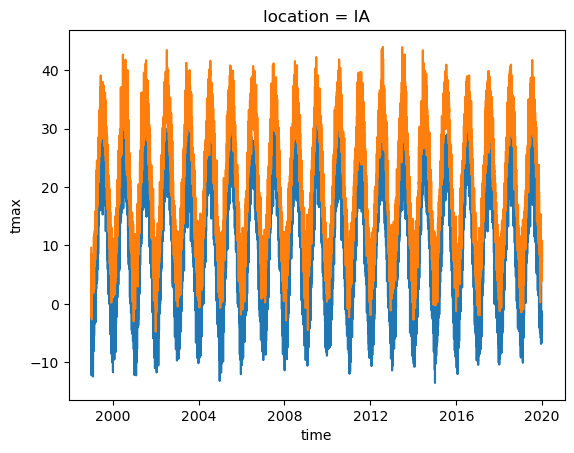

In [8]:
# some time series plots
ds.tmin.plot()
ds.tmax.plot()
plt.show()

## Lets now preprocess our dataset in preparation for training

- Lets structure the supervised learning problem (what is the input/feature(s)/label?)
- Since this is time series data and there is autocorrelation, we will split data into train and test set using years rather than randomly splitting data
- Standardize and normalize the training set

In [ ]:
# split by years
train = ds.sel(time=slice('1999-01-01T00:00:00.000000000','2014-12-31T00:00:00.000000000'))
test = ds.sel(time=slice('2015-01-01T00:00:00.000000000','2019-12-31T00:00:00.000000000'))

For random train test splitting, check out

`from sklearn.model_selection import train_test_split`

Now lets set up the input and label.

In [ ]:
input_train = train.tmin
label_train = train.tmax

And finally, let's go ahead and min-max scale our training data. We can levarage the sklearn function that will save our min and max values from the training set for us.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# create our scaler object
scaler_input = MinMaxScaler()
scaler_label = MinMaxScaler()

In [ ]:
scaler_input.fit(input_train)

In [ ]:
scaler_label.fit(label_train)

In [ ]:
print(scaler_input.data_max_)
print(scaler_input.data_min_)

In [ ]:
print(scaler_label.data_max_)
print(scaler_label.data_min_)

In [ ]:
input_train_scaled = scaler_input.transform(input_train)
label_train_scaled = scaler_label.transform(label_train)

Let's confirm that this worked!

In [ ]:
plt.plot(range(0,input_train_scaled.shape[0]), input_train_scaled, c='k')
plt.show()
plt.plot(range(0,input_train_scaled.shape[0]), input_train, c='r')
plt.show()

In [ ]:
plt.plot(range(0,label_train_scaled.shape[0]), label_train_scaled, c='k')
plt.show()
plt.plot(range(0,label_train_scaled.shape[0]), label_train, c='r')
plt.show()

In [ ]:
# bin data / create classes (labels)
# integer encoding
# one-hot encoding

Now that our toy data in ready, including our input variable and the label, lets build our ANN (artificial neural network)

# ANN Time!

Documentation: https://keras.io/api/models/sequential/

In [ ]:
model = keras.Sequential() # instantiate model object

Creating our input layer (not required, but I recommend this because it lets the model get built continuously as you are adding layers rather than waiting till the end to build).

In [ ]:
model.add(keras.Input(shape=(1,), name="input_layer"))

Docs: https://keras.io/api/layers/core_layers/input/

Now lets add our hidden layers

In [ ]:
model.add(
    keras.layers.Dense(units=8, activation=keras.activations.relu))
model.add(
    keras.layers.Dense(units=8, activation=keras.activations.relu))

Docs: https://keras.io/api/layers/core_layers/dense/

Output layer for classification

In [ ]:
# integer encoding
model.add(keras.layers.Dense(units=1, activation='sigmoid'))
# one-hot
model.add(keras.layers.Dense(units=1, activation='softmax'))

Now compiling our model. We will use gradient descent (with momentum) optimizer called SGD and MSE as a loss function.

For more options and docs, see:

- https://keras.io/api/optimizers/
- https://keras.io/api/losses/

In [ ]:
# integer
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    loss=keras.losses.BinaryCrossentropy()
)

# one-hot
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    loss=keras.losses.CategoricalCrossentropy()
)

What does our model "look" like?

In [ ]:
model.summary()

Call model.fit to train! YAY :)

Documentation: https://keras.io/api/models/model_training_apis/

In [ ]:
history = model.fit(
    x=input_train_scaled,
    y=label_train_scaled,
    batch_size=32,
    epochs=20,
    verbose='auto',
    validation_split=0.1,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
)

Lets plot our training and validation loss curves.

In [ ]:
plt.plot(range(0,20), history.history['loss'], c='k', label='loss')
plt.plot(range(0,20), history.history['val_loss'], c='r', label='val_loss')
plt.legend()
plt.show()

# Now lets do inference

How does our model perform on the testing set?

Rescale our test data using our earlier scaler objects

In [ ]:
input_test = test.tmin
label_test = test.tmax

input_test_scaled = scaler_input.transform(input_test)
label_test_scaled = scaler_label.transform(label_test)

Quick double check!

In [ ]:
plt.plot(range(0,input_test_scaled.shape[0]), input_test_scaled, c='k')
plt.show()
plt.plot(range(0,input_test_scaled.shape[0]), input_test, c='r')
plt.show()

In [ ]:
plt.plot(range(0,label_test_scaled.shape[0]), label_test_scaled, c='k')
plt.show()
plt.plot(range(0,label_test_scaled.shape[0]), label_test, c='r')
plt.show()

In [ ]:
# to predict, use predict call
predictions = model.predict(
    x=input_test_scaled,
)

In [ ]:
plt.scatter(label_test_scaled, predictions)
plt.xlabel('Labels')
plt.ylabel('ML predictions')
plt.show()

In [ ]:
# MSE
# np.mean(square(y_true - y_pred))
np.mean(np.square(label_test_scaled - predictions))